In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/rampaln/envs/ml_env_v2/share/proj failed


In [3]:
import glob
from dask.diagnostics import ProgressBar

In [4]:
AI_indicators = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/NIWA-REMS_AI_P_T_indicators_final_v150425.nc')

In [6]:
static_fields = xr.open_dataset(r'/nesi/project/niwa03712/group_shared/Emulator_training_data/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

In [7]:
merged_dset_updated = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Low_res_ACCESS-ESM1-5_ensemble.nc')

In [ ]:
## Some Case Studys of very rare "record shattering" events

In [8]:
merged_dset_updated

<xarray.Dataset>
Dimensions:                 (GCM_variant: 40, season: 4, lat: 23, lon: 26, year: 151)
Coordinates:
  * GCM_variant             (GCM_variant) object 'ACCESS-ESM1-5_r10i1p1f1' .....
  * lon                     (lon) float64 150.6 152.1 153.6 ... 186.6 188.1
  * lat                     (lat) float64 -59.38 -57.88 -56.38 ... -27.88 -26.38
    height                  float64 ...
    height_2                float64 ...
  * season                  (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * year                    (year) int64 1950 1951 1952 1953 ... 2098 2099 2100
Data variables:
    tasmax_seasonal_future  (GCM_variant, season, lat, lon) float32 ...
    pr_seasonal_future      (GCM_variant, season, lat, lon) float32 ...
    tasmax_seasonal_hist    (GCM_variant, season, lat, lon) float32 ...
    pr_seasonal_hist        (GCM_variant, season, lat, lon) float32 ...
    TXx                     (GCM_variant, year, lat, lon) float32 ...
    Rx1day                  (GCM_variant, year, lat, lon) float32 ...

In [9]:
rx1day = xr.open_dataset(r'/nesi/project/niwa00018/gibsonp/dload_data/VCSN_Rain_Council/rainfall_council_ni_si_start_cumulation.nc').groupby('time.year').max()#.sel(time = slice("1986","2005"))
txx = xr.open_dataset(r'/nesi/project/niwa00004/ML_DATA/VCSN/temperature_maximum/tmax_N/VCSN_Tmaxn5k_1972-2018.nc').groupby('time.year').max()#.sel(time = slice("1986","2005")).ffill("latitude",limit =2).ffill("longitude",limit =2)


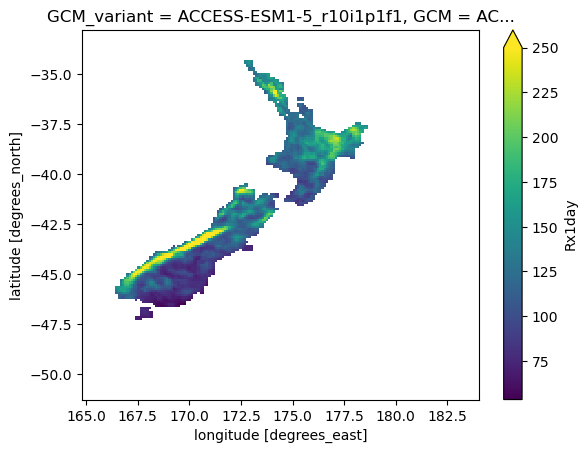

In [31]:
AI_indicators.isel(GCM_variant =1).sel(year = slice(1960, 2014)).Rx1day.rolling(year =10).max()[::10].mean("year").where(static_fields.orog>0, np.nan).plot(vmax =250)

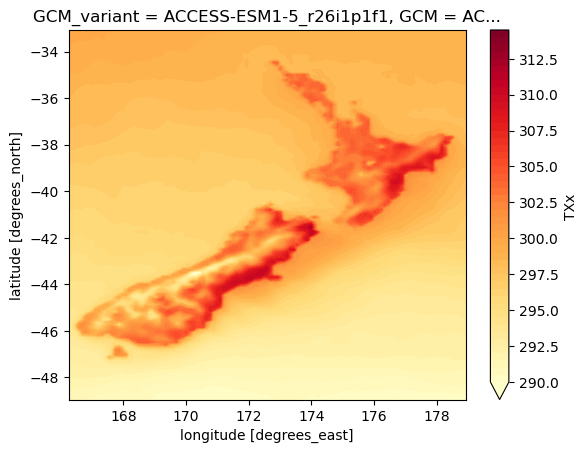

In [44]:
AI_indicators.isel(GCM_variant =18).sel(year = slice(1960, 2014), lat = slice(-49, -33), lon = slice(166.25, 178.95)).TXx.rolling(year =10).max()[::10].mean("year").plot.contourf(levels = np.arange(290, 315, 0.5), cmap ='YlOrRd')

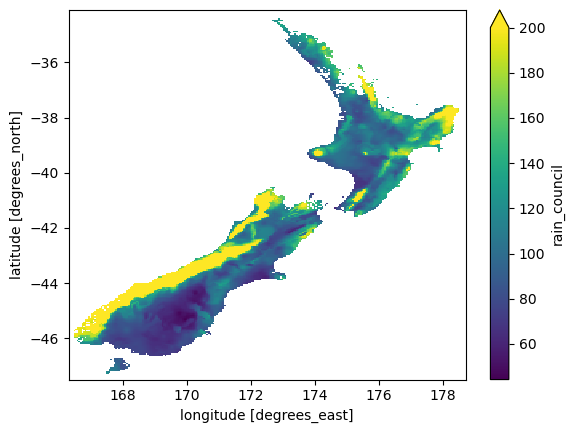

In [15]:
rx1day.rolling(year =10).max().mean("year").rain_council.plot(vmax =200)

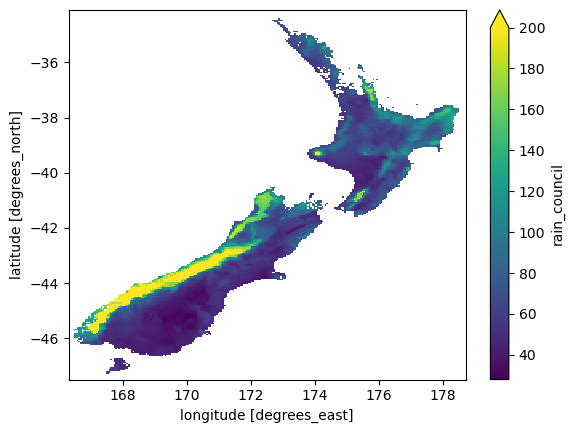

In [14]:
rx1day.rolling(year =10).mean().mean("year").rain_council.plot(vmax =200)

In [40]:
var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').Rx1day.sel(year = slice(1973, 2021)).std(["year","GCM_variant"])
var2 = rx1day.rain_council.isel(year = slice(1, None)).std("year")
var3 = (merged_dset_updated.Rx1day.sel(year = slice(1973, 2021))*86400).std(["year","GCM_variant"])
var3 = var3.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
var1 = var1.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
var3 = var3.where(~var2.isnull(), np.nan)
var1 = var1.where(~var2.isnull(), np.nan)

In [51]:
t_var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').TXx.sel(year = slice(1973, 2021)).std(["year","GCM_variant"])
t_var2 = txx.tmax.isel(year = slice(1, None)).std("year")
t_var3 = (merged_dset_updated.TXx.sel(year = slice(1973, 2021))).std(["year","GCM_variant"])
t_var3 = t_var3.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
t_var1 = t_var1.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
t_var3 = t_var3.where(~var2.isnull(), np.nan)
t_var1 = t_var1.where(~var2.isnull(), np.nan)

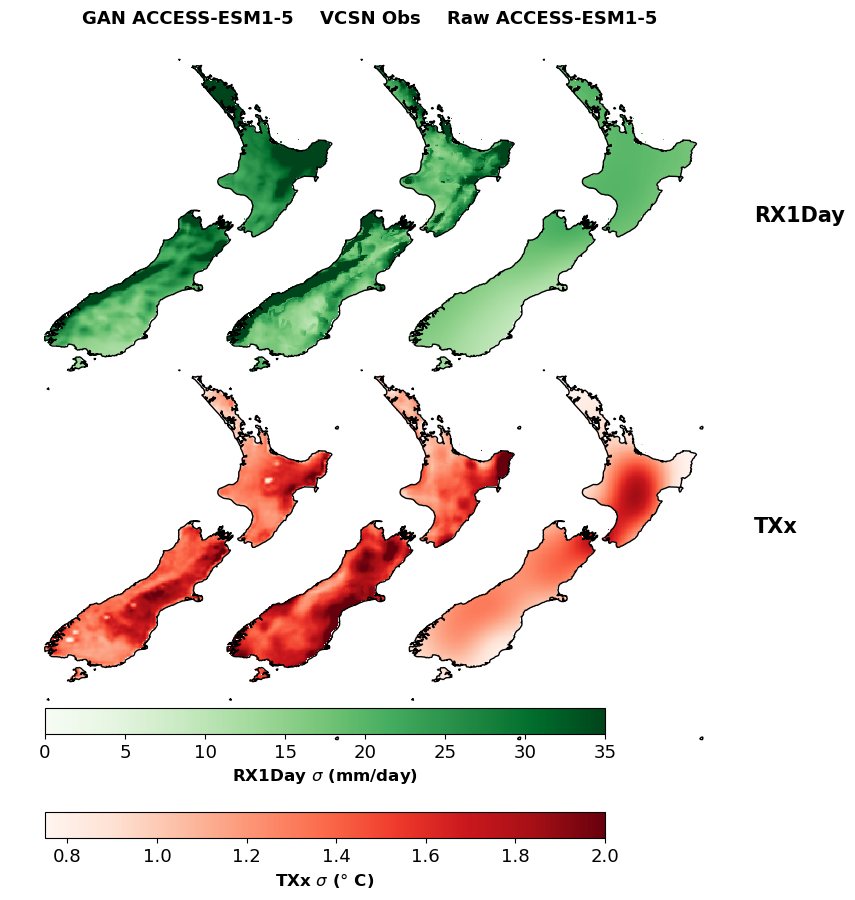

In [69]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# Set up figure and gridspec
fig = plt.figure(figsize=(14, 13
                         ))
gs = gridspec.GridSpec(2, 6, figure=fig, wspace=0.05, hspace=-0.55)
proj = ccrs.PlateCarree(central_longitude=171.77)

# Manually create axes with projection
ax00 = fig.add_subplot(gs[0, 0:2], projection=proj)
ax01 = fig.add_subplot(gs[0, 1:3], projection=proj)
ax02 = fig.add_subplot(gs[0, 2:4], projection=proj)
ax10 = fig.add_subplot(gs[1, 0:2], projection=proj)
ax11 = fig.add_subplot(gs[1, 1:3], projection=proj)
ax12 = fig.add_subplot(gs[1, 2:4], projection=proj)

# Plotting CCAM signals
var1.plot(
    cmap='Greens', vmin=0, vmax=35, ax=ax00, transform=ccrs.PlateCarree(), add_colorbar=False)
var2.plot(
    cmap='Greens', vmin=0, vmax=35, ax=ax01, transform=ccrs.PlateCarree(), add_colorbar=False)
cs2 = var3.plot(
    cmap='Greens', vmin=0, vmax=35, ax=ax02, transform=ccrs.PlateCarree(), add_colorbar=False)

# Plotting raw GCM signals
t_var1.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax10, transform=ccrs.PlateCarree(), add_colorbar=False)
t_var2.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax11, transform=ccrs.PlateCarree(), add_colorbar=False)
cs = t_var3.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax12, transform=ccrs.PlateCarree(), add_colorbar=False)

# Clean titles and frames
for ax in [ax00, ax01, ax02, ax10, ax11, ax12]:
    ax.set_title(' ')
    ax.set_frame_on(False)
    ax.coastlines('10m')
    ax.set_extent([165, 180, -50, -33], crs = ccrs.PlateCarree())
cbar_ax2 = fig.add_axes([0.15, 0.15, 0.4, 0.02])

cbar_ax = fig.add_axes([0.15, 0.23, 0.4, 0.02])
cbar = fig.colorbar(cs2, cax = cbar_ax, orientation ='horizontal')
cbar2 = fig.colorbar(cs, cax = cbar_ax2, orientation ='horizontal')
cbar.set_label('RX1Day $\sigma$ (mm/day)', fontsize =12, weight ='bold')
cbar2.set_label('TXx $\sigma$ ($\degree$ C)', fontsize =12, weight ='bold')
cbar.ax.tick_params(labelsize =13)
cbar2.ax.tick_params(labelsize =13)
ax00.set_title('GAN ACCESS-ESM1-5', weight ='bold', fontsize =13)
ax01.set_title('VCSN Obs', weight ='bold', fontsize =13)
ax02.set_title('Raw ACCESS-ESM1-5', weight ='bold', fontsize =13)
ax02.text(181, -41, 'RX1Day', fontsize =15, transform = ccrs.PlateCarree(), weight ='bold')
ax12.text(181, -41, 'TXx', fontsize =15, transform = ccrs.PlateCarree(), weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Historical_Variability_relative_to_observations.png', dpi =500, bbox_inches ='tight')
plt.show()

In [96]:
var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').Rx1day.sel(year = slice(1973, 2021))
var1 = (100 * (var1 - var1.mean("year"))/var1.mean("year")).std(["year","GCM_variant"])

var4 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='CanESM5').Rx1day.sel(year = slice(1973, 2021))
var4 = (100 * (var4 - var4.mean("year"))/var4.mean("year")).std(["year","GCM_variant"])

var2 = rx1day.rain_council.isel(year = slice(1, None))
var2 = (100 * (var2 - var2.mean("year"))/var2.mean("year")).std(["year"])
var3 = (merged_dset_updated.Rx1day.sel(year = slice(1973, 2021))*86400)
var3 = (100 * (var3 - var3.mean("year"))/var3.mean("year")).std(["year","GCM_variant"])
#.std(["year","GCM_variant"])
var3 = var3.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
var4 = var4.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
var1 = var1.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
var3 = var3.where(~var2.isnull(), np.nan)
var1 = var1.where(~var2.isnull(), np.nan)
var4 = var4.where(~var2.isnull(), np.nan)

/nesi/project/niwa00018/rampaln/envs/ml_env_v2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [95]:
t_var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').TXx.sel(year = slice(1973, 2021)).std(["year","GCM_variant"])
t_var4 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='CanESM5').TXx.sel(year = slice(1973, 2021)).std(["year","GCM_variant"])
t_var2 = txx.tmax.isel(year = slice(1, None)).std("year")
t_var3 = (merged_dset_updated.TXx.sel(year = slice(1973, 2021))).std(["year","GCM_variant"])
t_var3 = t_var3.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
t_var4 = t_var4.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
t_var1 = t_var1.interp(lat = var2.latitude, lon = var2.longitude, method ='cubic')
t_var3 = t_var3.where(~var2.isnull(), np.nan)
t_var4 = t_var4.where(~var2.isnull(), np.nan)
t_var1 = t_var1.where(~var2.isnull(), np.nan)

In [94]:
t_var4

<xarray.DataArray 'TXx' (lat: 172, lon: 179)>
array([[0.68501738, 0.6792463 , 0.67364867, ..., 0.68233366, 0.68585862,
        0.68987527],
       [0.66938607, 0.66458617, 0.66175995, ..., 0.68550878, 0.68921258,
        0.69277075],
       [0.6697537 , 0.66604637, 0.66438716, ..., 0.68747887, 0.68984317,
        0.69306336],
       ...,
       [0.77259171, 0.76940895, 0.76839335, ..., 0.72933692, 0.72374142,
        0.72319353],
       [0.77844448, 0.77536567, 0.7742099 , ..., 0.72775084, 0.72240189,
        0.72158613],
       [0.78379186, 0.78078201, 0.77845189, ..., 0.72692299, 0.72102318,
        0.7208881 ]])
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86

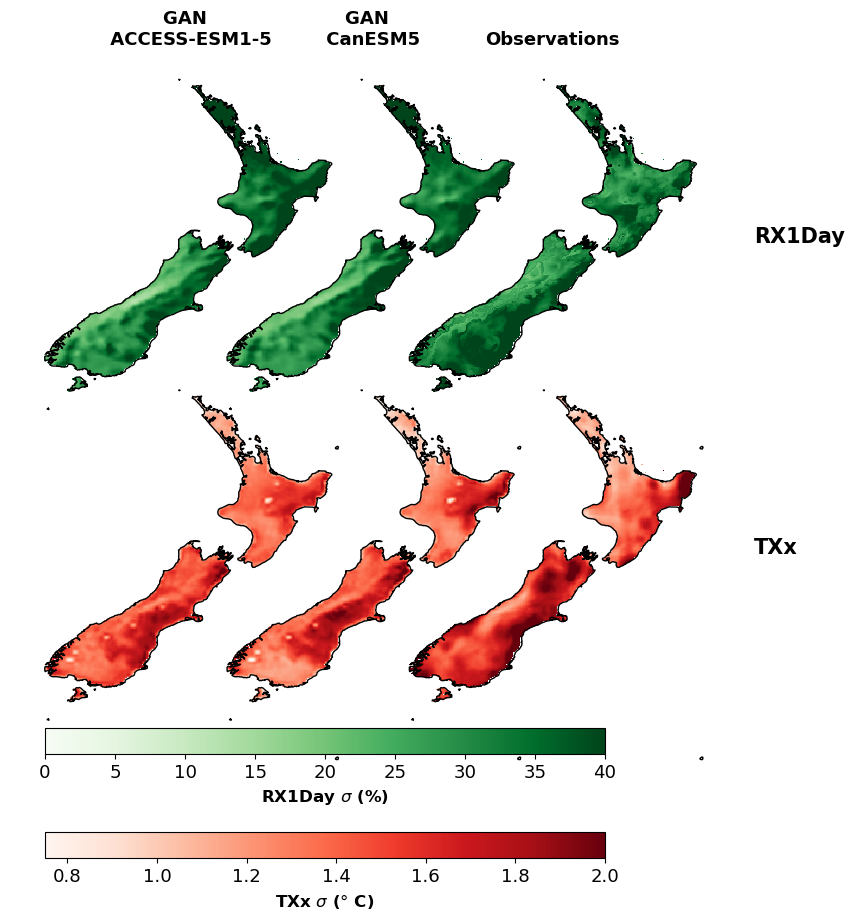

In [101]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# Set up figure and gridspec
fig = plt.figure(figsize=(14, 13
                         ))
gs = gridspec.GridSpec(2, 6, figure=fig, wspace=0.05, hspace=-0.55)
proj = ccrs.PlateCarree(central_longitude=171.77)

# Manually create axes with projection
ax00 = fig.add_subplot(gs[0, 0:2], projection=proj)
ax01 = fig.add_subplot(gs[0, 1:3], projection=proj)
ax02 = fig.add_subplot(gs[0, 2:4], projection=proj)
#ax03 = fig.add_subplot(gs[0, 3:5], projection=proj)
ax10 = fig.add_subplot(gs[1, 0:2], projection=proj)
ax11 = fig.add_subplot(gs[1, 1:3], projection=proj)
ax12 = fig.add_subplot(gs[1, 2:4], projection=proj)
#ax13 = fig.add_subplot(gs[1, 3:5], projection=proj)
# Plotting CCAM signals
var4.plot(
    cmap='Greens', vmin=0, vmax=40, ax=ax00, transform=ccrs.PlateCarree(), add_colorbar=False)
var1.plot(
    cmap='Greens', vmin=0, vmax=40, ax=ax01, transform=ccrs.PlateCarree(), add_colorbar=False)
# cs2 = var3.plot(
#     cmap='Greens', vmin=0, vmax=40, ax=ax02, transform=ccrs.PlateCarree(), add_colorbar=False)
cs2 = var2.plot(
    cmap='Greens', vmin=0, vmax=40, ax=ax02, transform=ccrs.PlateCarree(), add_colorbar=False)

# Plotting raw GCM signals
t_var4.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax10, transform=ccrs.PlateCarree(), add_colorbar=False)
t_var1.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax11, transform=ccrs.PlateCarree(), add_colorbar=False)
# cs = t_var3.plot(
#     cmap='Reds', vmin=0.75, vmax=2, ax=ax12, transform=ccrs.PlateCarree(), add_colorbar=False)

cs = t_var2.plot(
    cmap='Reds', vmin=0.75, vmax=2, ax=ax12, transform=ccrs.PlateCarree(), add_colorbar=False)


# Clean titles and frames
for ax in [ax00, ax01, ax02,ax03, ax10, ax11, ax12, ax13]:
    ax.set_title(' ')
    ax.set_frame_on(False)
    ax.coastlines('10m')
    ax.set_extent([165, 180, -50, -33], crs = ccrs.PlateCarree())
cbar_ax2 = fig.add_axes([0.15, 0.15, 0.4, 0.02])

cbar_ax = fig.add_axes([0.15, 0.23, 0.4, 0.02])
cbar = fig.colorbar(cs2, cax = cbar_ax, orientation ='horizontal')
cbar2 = fig.colorbar(cs, cax = cbar_ax2, orientation ='horizontal')
cbar.set_label('RX1Day $\sigma$ (%)', fontsize =12, weight ='bold')
cbar2.set_label('TXx $\sigma$ ($\degree$ C)', fontsize =12, weight ='bold')
cbar.ax.tick_params(labelsize =13)
cbar2.ax.tick_params(labelsize =13)
ax00.set_title('GAN \n ACCESS-ESM1-5', weight ='bold', fontsize =13)
ax02.set_title('Observations', weight ='bold', fontsize =13)
ax01.set_title('GAN \n CanESM5', weight ='bold', fontsize =13)
ax01.set_title('GAN \n CanESM5', weight ='bold', fontsize =13)
ax02.text(181, -41, 'RX1Day', fontsize =15, transform = ccrs.PlateCarree(), weight ='bold')
ax12.text(181, -41, 'TXx', fontsize =15, transform = ccrs.PlateCarree(), weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/CanESM5_vs_ACCESS-ESM1-5_hist_variability.png', dpi =500, bbox_inches ='tight')
plt.show()

In [75]:
var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').Rx1day.sel(year = slice(1973, 2021))
var1 = (100 * (var1 - var1.mean("year"))/var1.mean("year"))


var2 = rx1day.rain_council.isel(year = slice(1, None))
var2 = (100 * (var2 - var2.mean("year"))/var2.mean("year"))
var3 = (merged_dset_updated.Rx1day.sel(year = slice(1973, 2021))*86400)
var3 = (100 * (var3 - var3.mean("year"))/var3.mean("year"))
#.std(["year","GCM_variant"])


In [78]:
t_var1 = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').TXx.sel(year = slice(1973, 2021))
t_var2 = txx.tmax.isel(year = slice(1, None))
t_var3 = (merged_dset_updated.TXx.sel(year = slice(1973, 2021)))


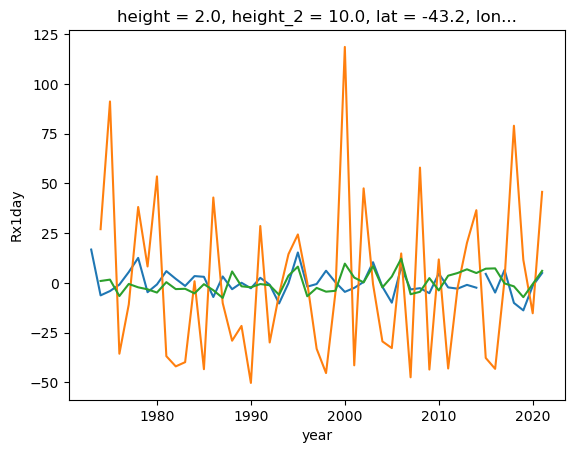

In [89]:
var1.interp(lat =-43.2, lon =172.5, method ='nearest').mean("GCM_variant").sel(year = slice(1973, 2021)).plot()
var2.interp(latitude =-43.2, longitude =172.5, method ='nearest').sel(year = slice(1974, 2021)).plot()
var3.interp(lat =-43.2, lon =172.5, method ='nearest').mean("GCM_variant").sel(year = slice(1974, 2021)).plot()

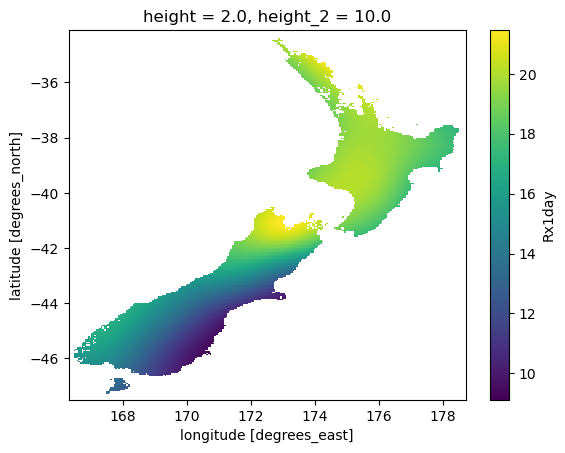

In [43]:
var3.plot()

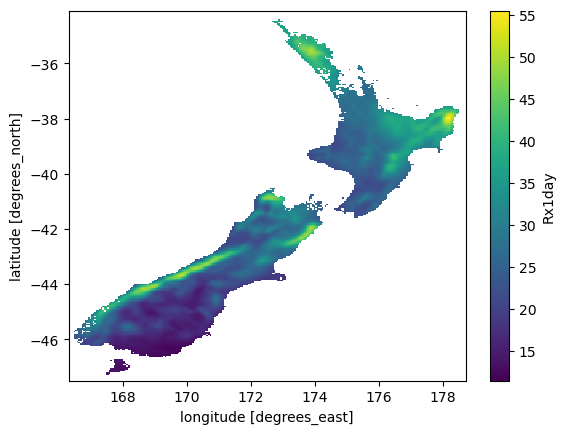

In [44]:
var1.plot()

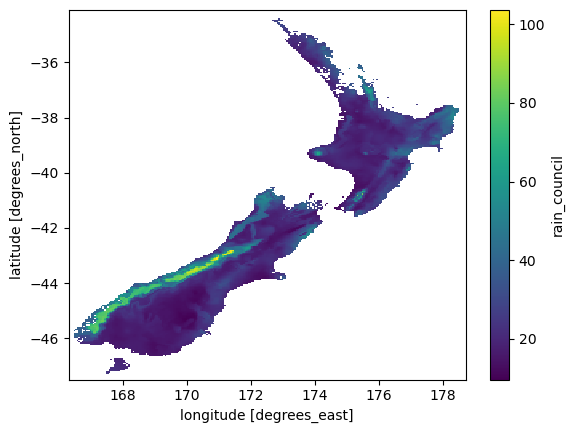

In [45]:
var2.plot()

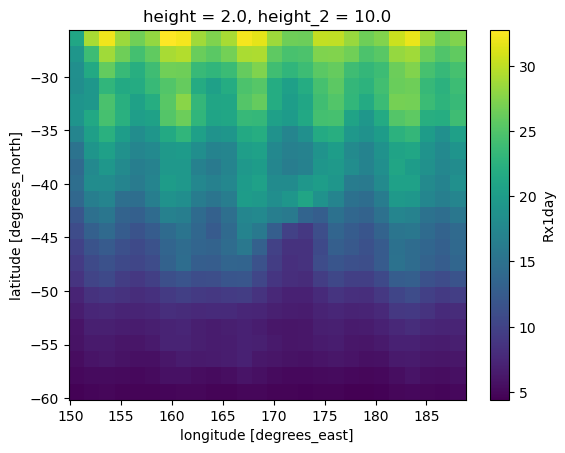

In [34]:
var3.plot()


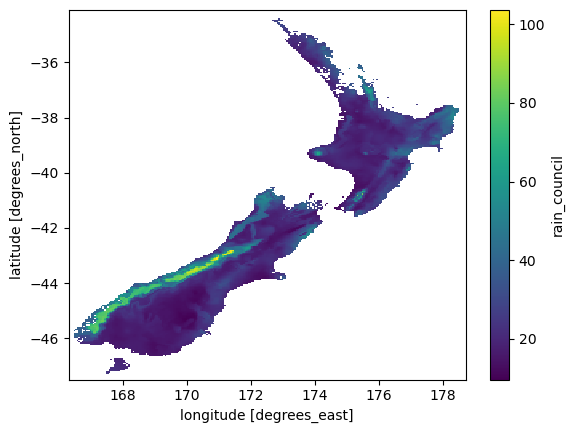

In [25]:
var2.plot()


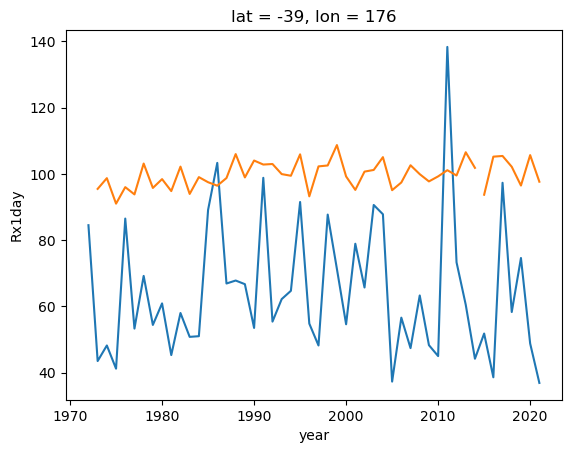

In [17]:
rx1day.interp(latitude =-39, longitude =176, method ='nearest').rain_council.isel(year = slice(1, None)).plot()
AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5').Rx1day.sel(year = slice(1973, 2021)).interp(lat=-39, lon =176, method ='nearest').mean("GCM_variant").plot()